## Entrenamiento del Modelo CNN

### Autor: Chavez Aquino, Cecilio

### Librerías

In [140]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import tensorflow as tf
import cv2
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

### Carga y lectura de datos acústicos

In [141]:
# Dataset: https://www.kaggle.com/datasets/julienjta/engine-acoustic-emissions/data
file_dataset = "D:/Rodamientos/dataset.mat"

# Cargar el archivo .mat
dataset = loadmat(file_dataset)
#cada clase es una señal de 12 segundos que se muestreó a una frecuencia de 10Khz, es decir 120000 muestras por clase

# Revisar las clases del archivo
print("Claves en el archivo .mat:")
print(dataset.keys())

# Extraer datos de cada clase
data_normal = dataset["normal"]
data_inner = dataset["inner"]
data_roller = dataset["roller"]
data_outer = dataset["outer"]

# Revisar las formas de las señales
print("Formas de los datos por clase:")
print(f"Normal: {data_normal.shape}")
print(f"Inner: {data_inner.shape}")
print(f"Roller: {data_roller.shape}")
print(f"Outer: {data_outer.shape}")




Claves en el archivo .mat:
dict_keys(['__header__', '__version__', '__globals__', 'normal', 'inner', 'roller', 'outer'])
Formas de los datos por clase:
Normal: (1, 120000)
Inner: (1, 120000)
Roller: (1, 120000)
Outer: (1, 120000)


### Segmentación de las señales

In [143]:
Ancho_segmento = 0.2 # vamos a considerar una tamaño de segmento de 0.2 segundos de 10000 datos por segundo que equivale a 2000 muestras
Frec_muestreo = 10000
muestras_segmento = Ancho_segmento * Frec_muestreo
duration_samples = 2000 # muestras_segmento

# Función para segmentar datos
def segment_signal(data, segment_length):

    # Convertir a 1D si está en 2D
    data = data.flatten()
    # Calcular el número total de segmentos posibles
    n_segments = len(data) // segment_length
    # Generar segmentos dividiendo directamente la matriz
    return np.array(np.split(data[:n_segments * segment_length], n_segments))

# Aplicar segmentación a cada clase
data_normal_segments = segment_signal(data_normal, duration_samples)
data_inner_segments = segment_signal(data_inner, duration_samples)
data_roller_segments = segment_signal(data_roller, duration_samples)
data_outer_segments = segment_signal(data_outer, duration_samples)

# Verificar formas de los datos segmentados
print("Formas después de segmentar:")
print(f"Normal: {data_normal_segments.shape}")
print(f"Inner: {data_inner_segments.shape}")
print(f"Roller: {data_roller_segments.shape}")
print(f"Outer: {data_outer_segments.shape}")

# Concatenar todos los datos segmentados
segmented_data = np.concatenate([data_normal_segments, data_inner_segments, data_roller_segments, data_outer_segments], axis=0)

# Crear etiquetas para cada clase antes de segmentar
labels = {
    "normal": 0,
    "inner": 1,
    "roller": 2,
    "outer": 3,
}

# Crear etiquetas correspondientes
labels = {"normal": 0, "inner": 1, "roller": 2, "outer": 3}
segmented_targets = np.concatenate([
    np.full(data_normal_segments.shape[0], labels["normal"]),
    np.full(data_inner_segments.shape[0], labels["inner"]),
    np.full(data_roller_segments.shape[0], labels["roller"]),
    np.full(data_outer_segments.shape[0], labels["outer"]),
])

# Verificar las formas finales
print("Datos segmentados:", segmented_data.shape)
print("Etiquetas correspondientes:", segmented_targets.shape)
# Verificar las etiquetas generadas
print("Etiquetas únicas después de la asignación inicial:", np.unique(segmented_targets))


Formas después de segmentar:
Normal: (60, 2000)
Inner: (60, 2000)
Roller: (60, 2000)
Outer: (60, 2000)
Datos segmentados: (240, 2000)
Etiquetas correspondientes: (240,)
Etiquetas únicas después de la asignación inicial: [0 1 2 3]


#### Se obtuvieron 120 segmentos de 1000 muestras para cada clase

### Conversión de datos a Espectrogramas Mel

### Selección de espectrograma
#### De acuerdo a la tabla mostrada se seleccionpó el espetrograma Mel ya que es usado normalmente en reconcimeinto de audio


| **Tipo**                  | **Escala de Frecuencia** | **Resolución Temporal** | **Resolución Frecuencial** | **Uso Principal**             |
|---------------------------|--------------------------|--------------------------|-----------------------------|--------------------------------|
| Espectrograma estándar    | Lineal                  | Alta                    | Media                      | General                       |
| Espectrograma logarítmico | Logarítmica             | Alta                    | Media                      | Señales acústicas y vocales   |
| Espectrograma Mel         | Mel (perceptual)        | Media                   | Media                      | Reconocimiento de audio       |
| Espectrograma de Chroma   | Cromática (musical)     | Baja                    | Alta                       | Análisis musical              |
| Espectrograma CQT         | Logarítmica             | Baja                    | Alta                       | Música, patrones armónicos    |
| MFCCs                     | Mel + Cepstral          | Baja                    | Baja                       | Reconocimiento de patrones    |
| Espectrograma Wavelet     | Depende de wavelet      | Alta para frecuencias altas | Alta para frecuencias bajas | Transitorios y vibraciones    |


In [144]:
sr = 10000  # Frecuencia de muestreo 10Khz
n_mels = 64  # Número de bandas Mel
n_fft = 512  # Tamaño de la ventana FFT
hop_length = 256  # Desplazamiento entre ventanas

# Función para convertir señales a espectrogramas Mel
def signal_to_mel_spectrogram(signal, sr=10000, n_mels=64, n_fft=512, hop_length=256):
   
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Convertir los segmentos de cada clase a espectrogramas
spectrograms_normal = [signal_to_mel_spectrogram(signal) for signal in data_normal_segments]
spectrograms_inner = [signal_to_mel_spectrogram(signal) for signal in data_inner_segments]
spectrograms_roller = [signal_to_mel_spectrogram(signal) for signal in data_roller_segments]
spectrograms_outer = [signal_to_mel_spectrogram(signal) for signal in data_outer_segments]

### Representación gráfica de los Espectrogramas

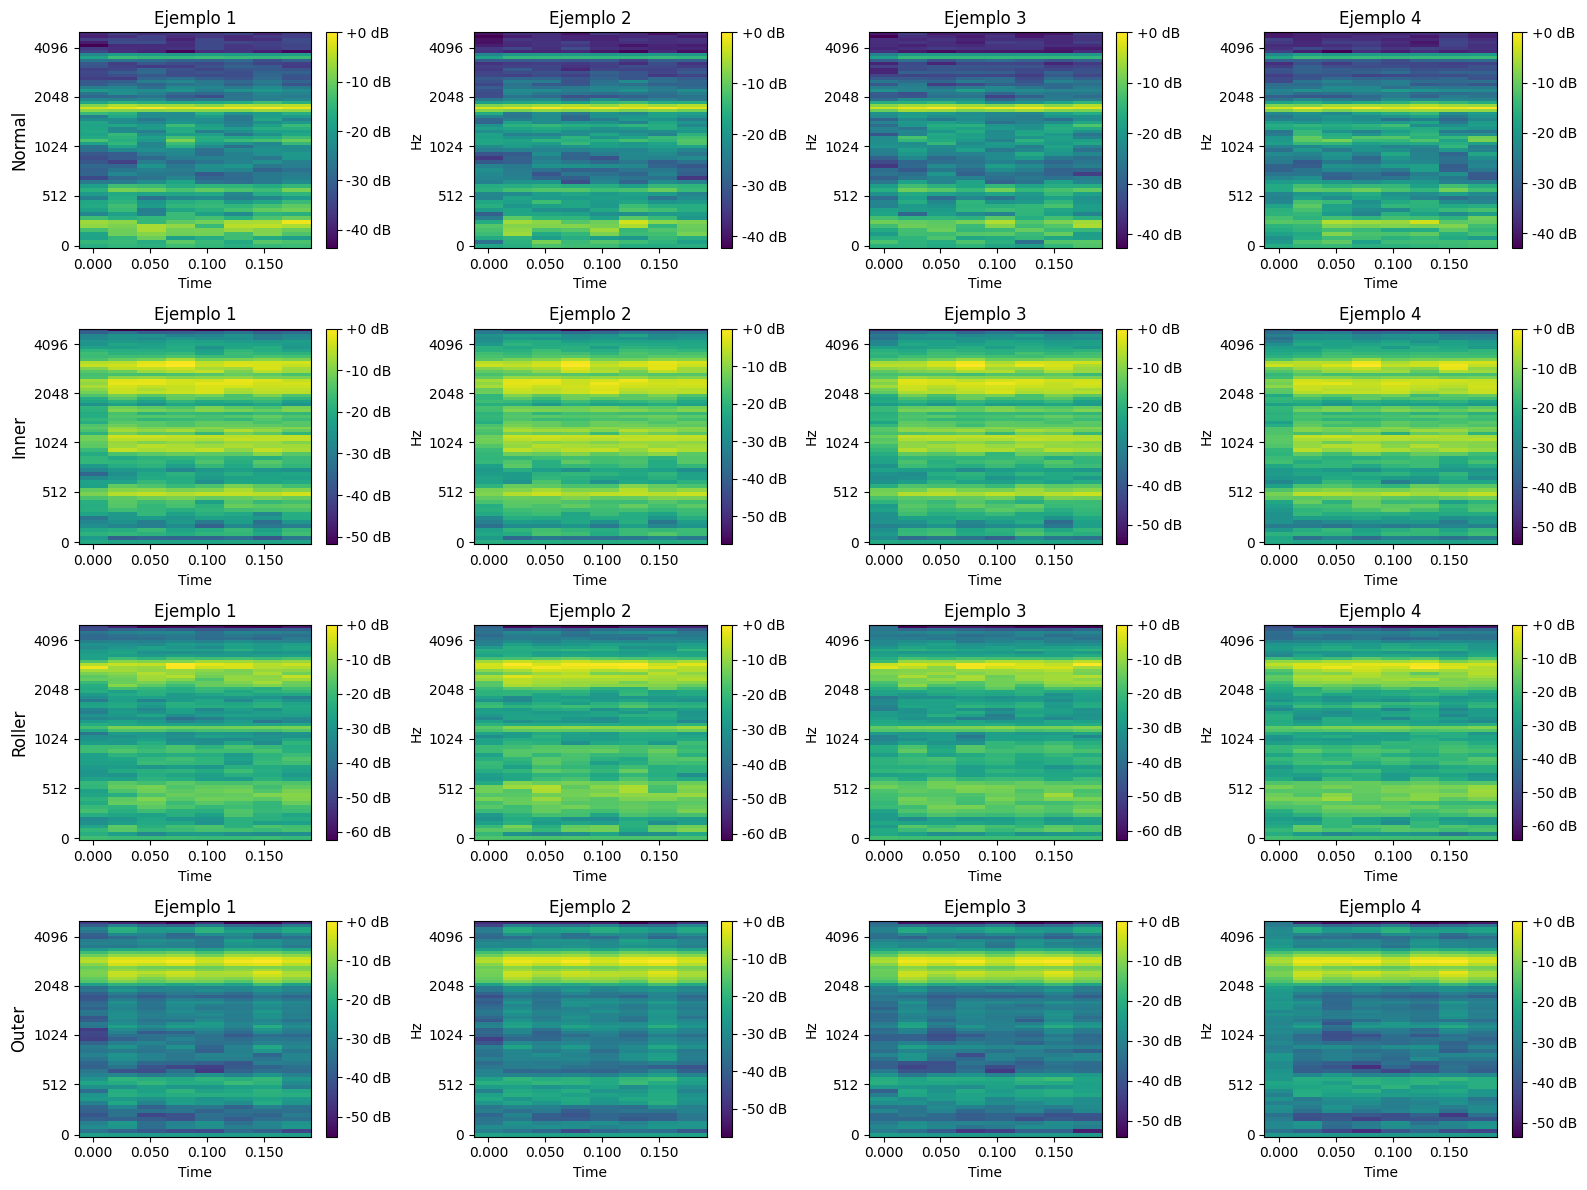

In [145]:
spectrograms = spectrograms_normal + spectrograms_inner + spectrograms_roller + spectrograms_outer
plt.figure(figsize=(16, 12))
classes = ['Normal', 'Inner', 'Roller', 'Outer']

for i, cls in enumerate(classes):
    start_idx = i * 60  # Cada clase tiene 60 segmentos
    for j in range(4):  # Mostrar 4 ejemplos por clase
        plt.subplot(4, 4, i * 4 + j + 1)
        librosa.display.specshow(spectrograms[start_idx + j], sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
        if j == 0:
            plt.ylabel(cls, fontsize=12)  # Etiqueta de la clase en el primer gráfico
        plt.title(f"Ejemplo {j+1}")
        plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

### Técnica de aumento de datos

In [146]:
def translate_spectrogram(spectrogram, shift_max=2):
    """
    Desplaza un espectrograma horizontalmente.
    """
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(spectrogram, shift, axis=1)

# Función para añadir ruido al espectrograma
def add_noise(spectrogram, noise_level=0.03):
    """
    Añade ruido aleatorio al espectrograma.
    """
    noise = np.random.normal(0, noise_level, spectrogram.shape)
    return spectrogram + noise

# Función para aplicar dropout de bandas Mel
def mel_band_dropout(spectrogram, drop_prob=0.2):
    """
    Aplica dropout eliminando bandas Mel aleatorias.
    """
    spectrogram = spectrogram.copy()
    n_mels = spectrogram.shape[0]
    drop_mask = np.random.rand(n_mels) > drop_prob
    spectrogram[~drop_mask, :] = 0
    return spectrogram

# Función para escalar la amplitud del espectrograma
def scale_amplitude(spectrogram, scale_range=(0.8, 1.2)):
    """
    Escala el espectrograma multiplicándolo por un factor aleatorio.
    """
    scale = np.random.uniform(*scale_range)
    return spectrogram * scale

# Función para aplicar todas las transformaciones
def augment_spectrogram(spectrogram):
    """
    Aplica aumento de datos al espectrograma con transformaciones aleatorias.
    """
    augmented = spectrogram.copy()
    augmented = translate_spectrogram(augmented)
    augmented = add_noise(augmented)
    augmented = mel_band_dropout(augmented)
    augmented = scale_amplitude(augmented)
    return augmented

# Aplicar aumento de datos a los espectrogramas 
augmented_spectrograms = []
for spectrogram in spectrograms:  # Se trabaja con los espectrogramas antes de la normalización
    for _ in range(3):  # Generar 3 variaciones por espectrograma
        augmented_spectrograms.append(augment_spectrogram(spectrogram))

# Convertir la lista a un array numpy
augmented_spectrograms = np.array(augmented_spectrograms)

# Verificar las dimensiones después del aumento de datos
print("Dimensiones de los espectrogramas originales:", np.array(spectrograms).shape)
print("Dimensiones de los espectrogramas aumentados:", augmented_spectrograms.shape)


Dimensiones de los espectrogramas originales: (240, 64, 8)
Dimensiones de los espectrogramas aumentados: (720, 64, 8)


### Interpolación de los espectrogramas para ajustarlos a 64x64

Dimensiones de los espectrogramas originales después de interpolación: (240, 64, 64)
Dimensiones de los espectrogramas aumentados después de interpolación: (720, 64, 64)
Dimensiones finales de los datos: (960, 64, 64, 1)


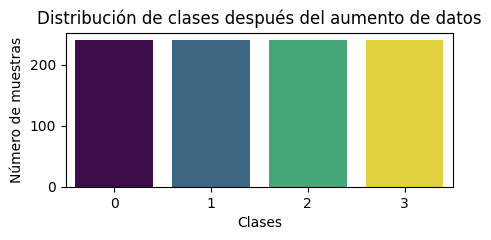

In [147]:
def interpolate_spectrograms(spectrograms, target_shape=(64, 64)):
    """
    Interpola cada espectrograma para ajustar su tamaño a 64x64.
    """
    interpolated_spectrograms = np.array([
        resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)
        for spectrogram in spectrograms
    ])
    return interpolated_spectrograms

# Aplicar interpolación a los espectrogramas originales y aumentados
interpolated_originals = interpolate_spectrograms(np.array(spectrograms))
interpolated_augmented = interpolate_spectrograms(np.array(augmented_spectrograms))

# Concatenar los espectrogramas originales con los aumentados
final_spectrograms = np.concatenate([interpolated_originals, interpolated_augmented], axis=0)
final_spectrograms = np.expand_dims(final_spectrograms, axis=-1)

# Verificar las dimensiones finales
print("Dimensiones de los espectrogramas originales después de interpolación:", interpolated_originals.shape)
print("Dimensiones de los espectrogramas aumentados después de interpolación:", interpolated_augmented.shape)
print("Dimensiones finales de los datos:", final_spectrograms.shape)

# Generar etiquetas para verificar balance de clases
num_originals = len(spectrograms)  # 480 originales
num_augmented = len(augmented_spectrograms)  # 1440 aumentados (3 por cada original)

# Generar etiquetas originales (suponiendo 4 clases balanceadas con 120 muestras cada una)
original_labels = np.repeat([0, 1, 2, 3], num_originals // 4)

# Generar etiquetas para los datos aumentados (cada original se triplica)
augmented_labels = np.repeat(original_labels, 3)

# Concatenar etiquetas
final_labels = np.concatenate([original_labels, augmented_labels])

# Visualizar la distribución de clases
plt.figure(figsize=(5, 2))
sns.countplot(x=final_labels, hue=final_labels, palette="viridis", legend=False)
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases después del aumento de datos")
plt.show()

### Normalización de espectrogramas [0, 1]

#### En este caso, la normalización es recomendable ya que hace que las activaciones dentro de la red sean más estables, ya que evita valores extremos que podrían saturar funciones de activación como ReLU

In [148]:
def normalize_spectrograms(spectrograms):
    """
    Normaliza los espectrogramas en el rango [0,1] usando Min-Max Scaling.
    """
    X_min = np.min(spectrograms)  # Valor mínimo global
    X_max = np.max(spectrograms)  # Valor máximo global
    normalized_spectrograms = (spectrograms - X_min) / (X_max - X_min)
    return normalized_spectrograms

# Aplicar normalización a los datos
normalized_spectrograms = normalize_spectrograms(final_spectrograms)

# Verificar dimensiones y rango después de la normalización
print("Dimensiones después de la normalización:", normalized_spectrograms.shape)
print(f"Rango de valores después de normalización: Min = {np.min(normalized_spectrograms)}, Max = {np.max(normalized_spectrograms)}")


Dimensiones después de la normalización: (960, 64, 64, 1)
Rango de valores después de normalización: Min = 0.0, Max = 1.0


### Partición de datos (70%, 15%, 15%)

In [149]:
X_train, X_temp, y_train, y_temp = train_test_split(normalized_spectrograms, final_labels, test_size=0.30, stratify=final_labels, random_state=42)
# Dividir el 30% restante en 15% validación y 15% prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Verificar tamaños
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}, {y_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}, {y_test.shape}")


Tamaño del conjunto de entrenamiento: (672, 64, 64, 1), (672,)
Tamaño del conjunto de validación: (144, 64, 64, 1), (144,)
Tamaño del conjunto de prueba: (144, 64, 64, 1), (144,)


### Modelo CNN

In [184]:
model = Sequential([
    Input(shape=(64, 64, 1)),  # Entrada de tamaño 64x64 con 1 canal

    # Primera capa convolucional + MaxPooling
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    # Segunda capa convolucional + MaxPooling
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    # Capa completamente conectada
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.8),

    # Capa de salida (4 clases con Softmax)
    Dense(4, activation='softmax') 
])

# Compilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()



Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_116 (Conv2D)             │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 32, 32, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,412 (2.02 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenameinto del modelo CNN

In [185]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2459 - loss: 1.4552 - val_accuracy: 0.2500 - val_loss: 1.3761
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2827 - loss: 1.3700 - val_accuracy: 0.6528 - val_loss: 1.3680
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2895 - loss: 1.3666 - val_accuracy: 0.2500 - val_loss: 1.3574
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3222 - loss: 1.3545 - val_accuracy: 0.2569 - val_loss: 1.3371
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3273 - loss: 1.3410 - val_accuracy: 0.5208 - val_loss: 1.3135
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3244 - loss: 1.3454 - val_accuracy: 0.5764 - val_loss: 1.2912
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3857 - loss: 1.3088 - val_accuracy: 0.5278 - val_loss: 1.2614
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3542 - loss: 1.2820 - val_accuracy: 0.5000 - v

### Representación gráfica de la Precisión y la Pérdida en el entrenamiento

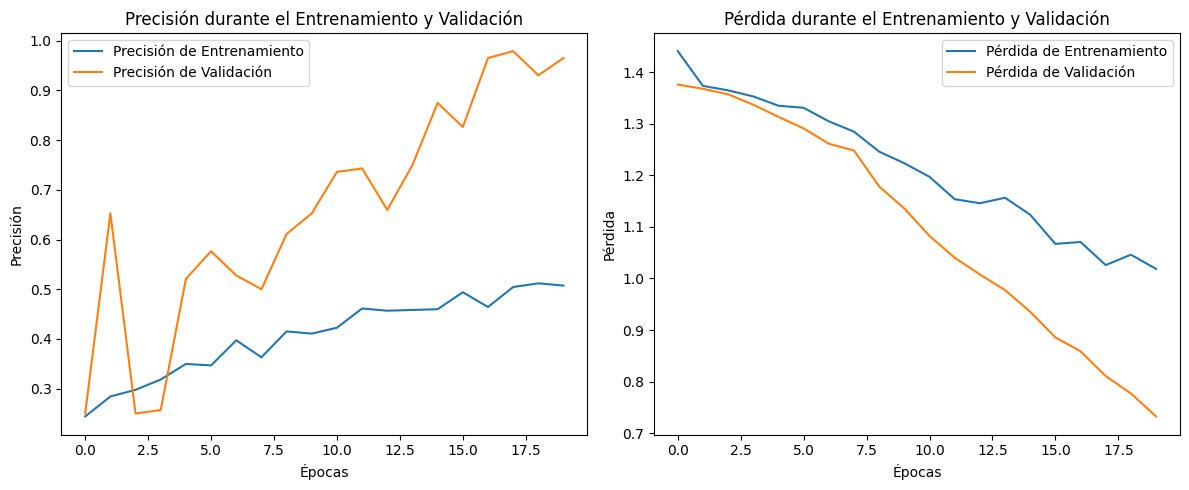

In [186]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear el gráfico
plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Precisión de Entrenamiento')
plt.plot(val_accuracy, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()



### Evaluación del modelo CNN

In [188]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

# Imprimir los resultados
print(f"Resultados de la evaluación:")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9760 - loss: 0.7476 
Resultados de la evaluación:
Pérdida en el conjunto de prueba: 0.7320
Precisión en el conjunto de prueba: 0.9722


### Matriz de confusión

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


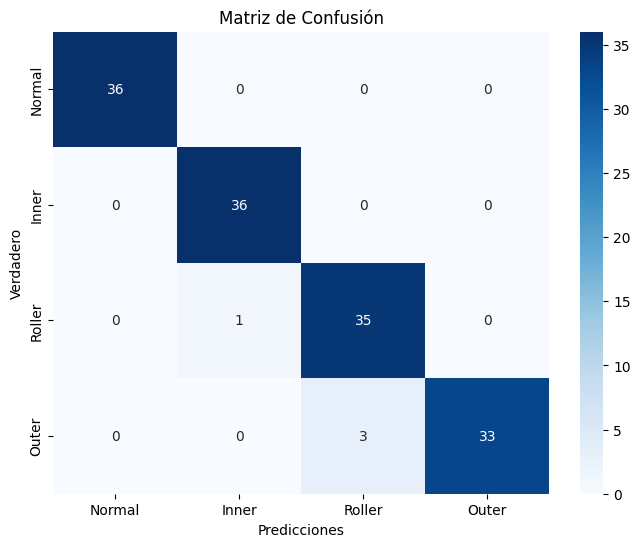

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        36
       Inner       0.97      1.00      0.99        36
      Roller       0.92      0.97      0.95        36
       Outer       1.00      0.92      0.96        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



In [190]:
class_names = ['Normal', 'Inner', 'Roller', 'Outer']

# Predicciones del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión con nombres de las clases
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación con nombres de las clases
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))
